# DRL Project

In this project, I implemented Deep Q Networks and Asynchronous Advantage Actor-Critic models and used them in two of the Atari games and simple gym environments.

## 1) Deep Q Networks (50)

DQN has two main features, namely target networks and replay buffer. However, additional improvements have been introduced since the first release of DQN.

- [Prioritized Replay Buffer](https://arxiv.org/pdf/1509.06461.pdf)
- [Double Deep Q Networks](https://arxiv.org/pdf/1511.05952.pdf)
- [Duelling Deep Q Networks](https://arxiv.org/pdf/1511.06581.pdf)

After implementing these methods, I compared combined algorithm with the vanilla DQN. For comparison I used two [gym](https://gym.openai.com/) environments. 
- [Lunar Lander](LunarLander-v2)
- [Pong](https://gym.openai.com/envs/Pong-v0/)



In [51]:
# In order to use modified modules without restarting
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import gym
import numpy as np
import torch

from blg604ehw2.dqn import episodic_test
from blg604ehw2.dqn import episodic_train

from blg604ehw2.network import Network
from blg604ehw2.network import FcNet
from blg604ehw2.network import DuellingHead
from blg604ehw2.network import SimpleHead

from blg604ehw2.utils import comparison
from blg604ehw2.utils import LoadingBar

### Lunar Lander with DQN (15)

In [53]:
def traindqn(env, agent, args, test_rate=1, epsilon_decay=5000):
    
    bar = LoadingBar(args.episode, "Episode")

#     agent.to(args.device)
    agent.device = args.device
    epsilon = args.max_epsilon

    time_step = 0
    rewards = []
    td_errors = []

    best_model = None
    best_rewards = []
    best_reward = -np.inf
        
    for eps in range(args.episode):
        ### YOUR CODE HERE ###
        
        # Training
        epsilon = lambda t: args.min_epsilon + (args.max_epsilon - args.min_epsilon) * np.exp(-1*(time_step + t)/epsilon_decay)
        elapsed_time, td_error = episodic_train(env, agent, args, epsilon)
        time_step += elapsed_time
        td_errors.append(td_error)
        
        # Testing
        test_reward = np.mean([episodic_test(env, agent, args) for _ in range(test_rate)])
        rewards.append(test_reward)
        
        if test_reward > best_reward:
            best_reward = test_reward
            best_model = agent.state_dict()
        best_rewards.append(best_reward)
        
        ###       END      ###
        bar.progress(eps, best_reward)
        
    bar.success(best_reward)
    return rewards, best_rewards, td_errors, time_step, best_model

### a) Vanilla DQN

In [54]:
from blg604ehw2.dqn import DQN
from blg604ehw2.dqn import ArgsDQN

# Set the environment name, you can try differnet environments.
envname = "LunarLander-v2"

# Hyperparameters for the traning
# You need to finetune some of the  hyperparameters!
env = gym.make(envname)
dqn_args = ArgsDQN(
        **dict(
            env_name=envname,           # Name of the environment
            nact=env.action_space.n,    # Number of actions
            buffersize=10000,           # Size of the replay buffer
            max_epsilon=0.9,            # Starting value of the epsilon
            min_epsilon=0.05,           # Convergence value of the epsilon
            target_update_period=100,   # Update period of the target network
            gamma=0.98,                 # Discount rate
            lr=0.001,                   # Learning rate
            device="cpu",               # Device name
            batch_size=128,             # Batch size
            episode=100,                # Number of episodes for training
            max_eps_len=400             # Maximum number of time steps in an episode
        )
    )




def dqn_agent():
    # Network construction
    feature_net = FcNet(env.observation_space.shape[0], 128)
    head_net = SimpleHead(env.action_space.n, 128)
    valuenet = Network(feature_net, head_net)
    
    # Initialize and return agent
    return DQN(
            valuenet = valuenet,
            nact = env.action_space.n,
            lr = dqn_args.lr,
            buffer_capacity = dqn_args.buffersize,
            target_update_period = dqn_args.target_update_period
)

/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [55]:
REPEAT = 3
lunar_dqn = []
for r in range(REPEAT):
    env = gym.make(dqn_args.env_name)
    agent = dqn_agent()
    lunar_dqn.append(traindqn(env, agent, dqn_args, test_rate=5))

/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


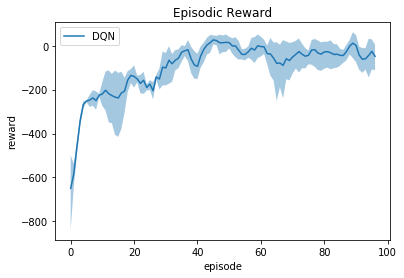

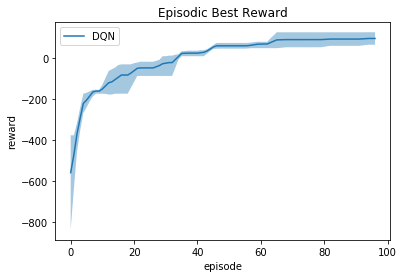

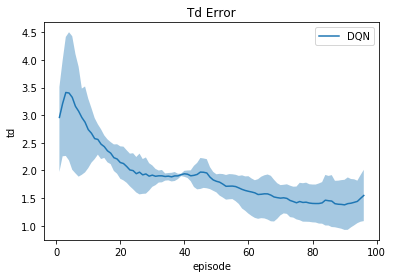

In [56]:
plot_texts = [
    [
        "Episodic Reward",
        "episode",
        "reward"
    ],
    [
        "Episodic Best Reward",
        "episode",
        "reward"
    ],
    [
        "Td Error",
        "episode",
        "td"
    ]
]
comparison((lunar_dqn, "DQN"), texts = plot_texts)

### b) Duelling Double Prioritized DQN (15)

In [65]:
from blg604ehw2.dqn import DuelingDoublePrioritizedDQN
from blg604ehw2.dqn import ArgsDDPQN


# Hyperparameters for the traning
# You need to finetune some of the hyperparameters!
envname = "LunarLander-v2"
env = gym.make(envname)
ddpdqn_args = ArgsDDPQN(
        **dict(
            env_name=envname,           # Name of the environment
            nact=env.action_space.n,    # Number of actions
            buffersize=10000,           # Size of the replay buffer
            max_epsilon=0.9,            # Starting value of the epsilon
            min_epsilon=0.1,            # Convergence value of the epsilon
            target_replace_period=50,#100  # Update period of the target network
            gamma=0.98,                 # Discount rate
            lr=0.001,                   # Learning rate
            device="cpu",               # Device name
            batch_size=128,             # Batch size
            episode=100,                # Number of episodes for training
            max_eps_len=400             # Maximum number of time steps in an episode
        )
    )

def ddpdqn_agent():
    # Network construction
    feature_net = FcNet(env.observation_space.shape[0], 128)
    head_net = DuellingHead(env.action_space.n, 128)
    valuenet = Network(feature_net, head_net)

    # Initialize agent
    return DuelingDoublePrioritizedDQN(
        valuenet = valuenet,
        nact = env.action_space.n,
        lr = ddpdqn_args.lr,
        buffer_capacity = ddpdqn_args.buffersize,
        target_replace_period = ddpdqn_args.target_replace_period
    )

/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [66]:
REPEAT = 3
lunar_ddpdqn = []
for r in range(REPEAT):
    env = gym.make(ddpdqn_args.env_name)
    agent = ddpdqn_agent()
    lunar_ddpdqn.append(traindqn(env, agent, ddpdqn_args, test_rate=5))

/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


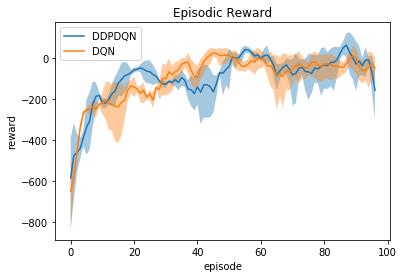

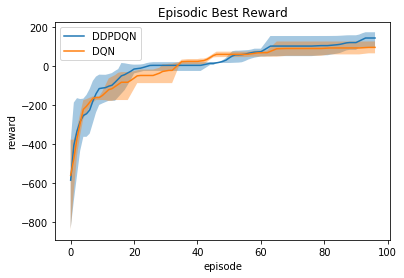

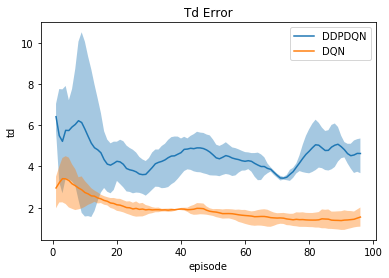

In [67]:
# In this cell, I had to remove the brackets making the first parameter a tuple.
# It was taking "(lunar_ddpdqn, "DDPDQN")" as logs and "(lunar_dqn, "DQN")" as names
# in the loop at the comparison function.
comparison((lunar_ddpdqn, "DDPDQN"), (lunar_dqn, "DQN"), texts = plot_texts)

You may compare these improvements by themselves if you want to. See which one of them makes the most improvement for the Lunar Lander environment.(optional)

#### Let's visualize the best agent

In [69]:
# Remember that due to the stochasticty of the
# environment it may perform differently for each run

# Assuming ddpdqn works better in your environment as it should be
best_agent_index = max(range(len(lunar_ddpdqn)), key = lambda i: lunar_ddpdqn[i][1][-1])
best_agent_state_dict = lunar_ddpdqn[best_agent_index][4]
best_agent = ddpdqn_agent()
best_agent.load_state_dict(best_agent_state_dict)

# Monitor saves the mp4 files under "monitor" folder.
monitor_path = "LunarLander/" + str(ddpdqn_args.episode) + " episode"
model_path = "monitor/LunarLander/model_state_dict"
episodic_test(agent=best_agent, env=gym.make(ddpdqn_args.env_name), args=ddpdqn_args, monitor_path=monitor_path)
torch.save(best_agent_state_dict, model_path)

/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Pong with Duelling Double Prioritized DQN (20)
- This may take long time

In [70]:
from blg604ehw2.atari_wrapper import ClipRewardEnv
from blg604ehw2.atari_wrapper import FrameStack
from blg604ehw2.atari_wrapper import EpisodicLifeEnv
from blg604ehw2.atari_wrapper import WarpFrame
from blg604ehw2.atari_wrapper import ScaledFloatFrame

from blg604ehw2.network import Cnn

envname = "Pong-v4"

# Wrapped atari environment.
# It is important to use these wrappers in order
# to simplfy learning. In their Nature paper,
# Deepmind used some of them to achive those
# results. It is good to check them and see 
# what they do.
def pongenv():
    env = gym.make(envname)
    env = ClipRewardEnv(env)            # Clip the reward between -1 and 1
    env = WarpFrame(env)                # Downsample rgb (210, 160, 3) images to gray images (84, 84)
    env = EpisodicLifeEnv(env)          # Terminate the environment after a live is lost
    env = FrameStack(env, k=4)          # Stack consecutive frames as a single state
    return env

# Hyperparameters for the traning
# This time parameter tunning is even more important!
# If you have access to a gpu use it! Set the device accordingly.
env = pongenv()
pong_args = ArgsDDPQN(
        **dict(
            env_name=envname,           # Name of the environment
            nact=env.action_space.n,    # Number of actions
            buffersize=100000,          # Size of the replay buffer
            max_epsilon=0.9,            # Starting value of the epsilon
            min_epsilon=0.1,            # Convergence value of the epsilon
            target_replace_period=1000, # Update period of the target network
            gamma=0.99,                 # Discount rate
            lr=0.0001,                  # Learning rate
            device="cpu",               # Device name
            batch_size=128,             # Batch size
            episode=1000,               # Number of episodes for training
            max_eps_len=2000            # Maximum number of time steps in an episode
        )
    )

def pong_agent():
    # Network construction
    feature_net = Cnn(4, 512)
    head_net = DuellingHead(env.action_space.n, 512)
    valuenet = Network(feature_net, head_net)

    # Initialize agent
    return DuelingDoublePrioritizedDQN(
        valuenet = valuenet,
        nact = env.action_space.n,
        lr = pong_args.lr,
        buffer_capacity = pong_args.buffersize,
        target_replace_period = pong_args.target_replace_period
    )

/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [71]:
REPEAT = 1 # Assign 1 if you dont want to train more than one
pong_ddpdqn = []
for r in range(REPEAT):
    env = pongenv()
    agent = pong_agent()
    pong_ddpdqn.append(traindqn(env, agent, pong_args, test_rate=3, epsilon_decay=100000))

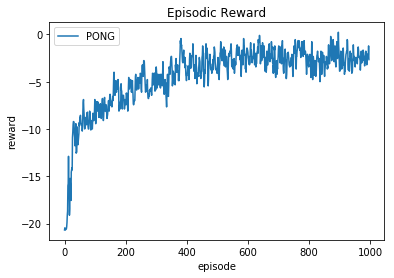

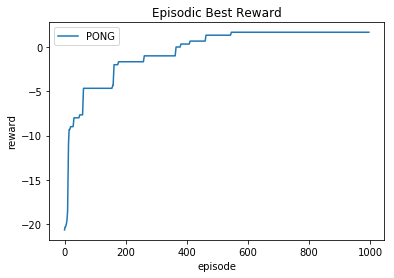

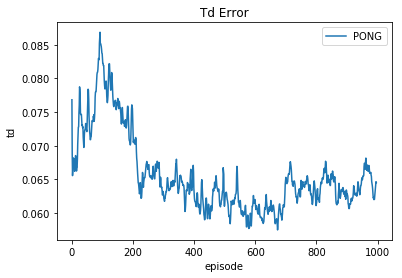

In [72]:
comparison((pong_ddpdqn, "PONG"), texts = plot_texts)

In [73]:
best_agent_index = max(range(len(pong_ddpdqn)), key = lambda i: pong_ddpdqn[i][1][-1])
best_agent_state_dict = pong_ddpdqn[best_agent_index][4]
best_agent = pong_agent() 
best_agent.load_state_dict(best_agent_state_dict)

# Monitor saves the mp4 files under "monitor" folder.
monitor_path = "Pong/" + str(pong_args.episode) + " episode"
model_path = "monitor/Pong/model_state_dict"
episodic_test(agent=best_agent, env=pongenv(), args=pong_args, monitor_path=monitor_path)
torch.save(best_agent_state_dict, model_path)

/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## 2) Asynchronous Advantage Actor-Critic (50)
[A3C](https://arxiv.org/abs/1602.01783) is a policy gradinet algorithm which is based on asynchronous updates of paralel agents.
You will be testing your agent in:

- [Bipedal Walker](https://gym.openai.com/envs/BipedalWalker-v2/)
- [Breakout](https://gym.openai.com/envs/Breakout-v0/)

### a) Bipedal Walker with Asynchronous Advantage Actor-Critic (20)
It is important to test your implementation with a simpler enviroment like BipedalWalker before trying Breakout.
It is highly recommended to check the pseudocode in the paper's appendix.

The implementation works as follows:

    - Create a global agent which's paremeters are in the shared memory.
    - Create multiple worker processes. That performs:
        - Gradient calculation with the transition it observed
        - Update the global agent with the gradients
        - Synchronize with the global agent
    - Create a test process that evaluates the performance of the global agent over the course of the training
    - Run these workers asynchronously
    
   

In [74]:
# In order to use modified modules without restarting
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import gym
from collections import namedtuple
import torch.multiprocessing as mp 

from blg604ehw2.network import FcNet
from blg604ehw2.network import ContinuousDistHead
from blg604ehw2.network import Network
from blg604ehw2.network import a3c_continuous

from blg604ehw2.a3c import ContinuousA3c
from blg604ehw2.a3c import SharedAdam
from blg604ehw2.a3c import train_worker
from blg604ehw2.a3c import test_worker
from blg604ehw2.a3c import A3C_args

import os
os.environ["OMP_NUM_THREADS"] = "1"

# Bipedal Walker environment is similar to Lunar Lander
# State space is a vector of length 24 and there are
# 4 actions
envname = "BipedalWalker-v2"

# Logger is a named tuple of shared lists integer and a model
# It is necessary to have a shared object since it can be used
# by many processes
Logger = namedtuple("Logger", "eps_reward best_reward best_model time_steps time")

# Hyperparameters, again tunning is necessary but optional.
a3c_args = A3C_args(
    **dict(
        maxtimestep=5000000,     # Number of time steps for training
        maxlen=2000,           # Maximum length of an episode
        nstep=20,               # Bootsrapping length (n-step td)
        gamma=0.99,             # Discount rate
        lr=0.0001,              # Learning rate
        beta=0.01,              # Entropy regularization constant
        device="cpu",           # Device
    )
)

# Agent generating function
# I tried to create my own network
# Since the old one didn't give me good results
def a3c_agent():
#     feature_net = FcNet(24)
#     head_net = ContinuousDistHead(128, 4)
#     network = Network(feature_net, head_net)
    
    network = a3c_continuous(24, 4)
    agent = ContinuousA3c(network)
    agent.device = a3c_args.device
    return agent

# Environment generating function
# You can use RewardClip wrapper
def walker_env():
    env =  gym.make(envname)
    return env
    

In [6]:
### Main cell for Bipedal Walker ###

# Number of training workers
N_PROCESSES = 8

# Global agent that will be used for synchronization.
global_agent = a3c_agent()
global_agent.share_memory()         # Make sure it is in the shared memory!

# Shared optimizer, since the optimizer has its own parameters
# they need to be in the shared memory as well.
sharedopt = SharedAdam(global_agent.parameters(), lr=a3c_args.lr)

# Another agent for logging purposes
best_agent = a3c_agent()
best_agent.share_memory()

# Logger
# Manager controls another process(server process) to share
# objects between multiple processes via proxies.
# Please read https://docs.python.org/3.7/library/multiprocessing.html
# for more information.
manager = mp.Manager()
logger = Logger(
    manager.list(),
    manager.list(),
    best_agent,
    manager.list(),
    manager.Value("i", 0)
)

# Lock is not necessary
lock = mp.Lock()

# Start by creating a test worker
processes = []
process = mp.Process(target=test_worker,
                     args=(a3c_args, global_agent, walker_env, a3c_agent, lock, logger))
process.start()
processes.append(process)

# Train workers
for t in range(N_PROCESSES):
    process = mp.Process(target=train_worker,
                         args=(a3c_args, global_agent, sharedopt, walker_env, a3c_agent, lock, logger))
    process.start()
    processes.append(process)

# It took some time to give good results
# So I saved the progress
import pickle
from time import sleep
def saver(logger, lock):
    print('Saver started!')
    while True:
        sleep(60 * 30)
        with lock:
            a = {
                'eps_reward': list(logger.eps_reward),
                'best_reward': list(logger.best_reward),
                'best_model': logger.best_model.state_dict(),
                'time_steps': list(logger.time_steps),
                'time': logger.time.value
            }
            with open(f'walker_checkpoints/walker_logger_time_{logger.time.value}.pkl', 'wb') as handle:
                pickle.dump(a, handle)
            print('Saved at time', logger.time.value)
            if logger.time.value >= ac3_args.maxtimestep:
                break
process = mp.Process(target=saver, args=(logger, lock))
process.start()
processes.append(process)

# Wait until all done
for p in processes:
    p.join()

/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Saver started!
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Time 00h 01m 21s, episode reward -30.78515743685492, episode length 1600
Time 00h 02m 27s, episode reward -107.37108480369797, episode length 104
Time 00h 04m 42s, episode reward -106.0357470622543, episode l

Time 02h 10m 20s, episode reward -90.22041850861194, episode length 86
Time 02h 11m 25s, episode reward -90.10517519938355, episode length 99
Time 02h 12m 30s, episode reward -90.4085482965121, episode length 99
Time 02h 13m 40s, episode reward -83.80932493261528, episode length 146
Time 02h 14m 46s, episode reward -82.1558266023025, episode length 136
Time 02h 15m 53s, episode reward -85.95830511785718, episode length 105
Time 02h 16m 57s, episode reward -90.23646953451261, episode length 90
Time 02h 18m 04s, episode reward -88.912142308043, episode length 97
Time 02h 19m 13s, episode reward -80.94689989436093, episode length 150
Time 02h 21m 26s, episode reward 57.34005917764618, episode length 1600
Time 02h 22m 29s, episode reward -88.62376442501446, episode length 90
Time 02h 24m 50s, episode reward -19.41291668565188, episode length 1600
Time 02h 25m 58s, episode reward -86.61163366156289, episode length 126
Time 02h 27m 03s, episode reward -88.57894586024767, episode length 98
Ti

Time 05h 03m 19s, episode reward -4.4977686816866935, episode length 360
Time 05h 05m 32s, episode reward 302.4072908580822, episode length 1352
Time 05h 06m 45s, episode reward -44.4877967045872, episode length 238
Time 05h 08m 45s, episode reward 308.11949128354354, episode length 1171
Time 05h 11m 10s, episode reward 291.7419730817329, episode length 1592
Time 05h 13m 14s, episode reward 302.6762924929662, episode length 1250
Time 05h 15m 20s, episode reward 292.82879745468244, episode length 1341
Time 05h 16m 39s, episode reward 5.058090892755104, episode length 434
Time 05h 17m 49s, episode reward -59.091224923629916, episode length 177
Time 05h 18m 53s, episode reward -85.72679792424722, episode length 105
Time 05h 20m 32s, episode reward 63.46227540311682, episode length 688
Time 05h 22m 39s, episode reward 303.12411377262316, episode length 1370
Time 05h 24m 50s, episode reward 302.42279364915737, episode length 1314
Time 05h 26m 43s, episode reward 311.51271581710216, episode 

Time 08h 37m 21s, episode reward 314.3788381506516, episode length 1064
Time 08h 39m 21s, episode reward 309.0736505820831, episode length 1182
Time 08h 41m 16s, episode reward 309.97242547161164, episode length 1162
Time 08h 43m 15s, episode reward 309.6300097464096, episode length 1177
Time 08h 45m 08s, episode reward 311.2757371653277, episode length 1156
Time 08h 47m 05s, episode reward 312.8488492806455, episode length 1102
Time 08h 49m 09s, episode reward 306.975073039811, episode length 1272
Time 08h 50m 16s, episode reward -75.91852396408065, episode length 122
Time 08h 51m 34s, episode reward -1.4824681921318614, episode length 364
Time 08h 53m 17s, episode reward 93.6686757322156, episode length 843
Time 08h 55m 09s, episode reward 308.81804665486055, episode length 1128
Time 08h 57m 12s, episode reward 307.702961419122, episode length 1193
Time 08h 59m 17s, episode reward 308.1355699027159, episode length 1175
Saved at time 2648416
Time 09h 01m 13s, episode reward 308.277679

Time 12h 08m 34s, episode reward 298.74651564788996, episode length 1288
Time 12h 10m 22s, episode reward 310.393060120453, episode length 1073
Time 12h 12m 12s, episode reward 316.7649354416443, episode length 1018
Time 12h 14m 08s, episode reward 310.9633083001546, episode length 1105
Time 12h 16m 08s, episode reward 305.14452585842736, episode length 1159
Time 12h 17m 55s, episode reward 316.89436724310553, episode length 990
Time 12h 20m 00s, episode reward 307.2672638425256, episode length 1178
Time 12h 22m 00s, episode reward 314.0859393513699, episode length 1062
Time 12h 23m 49s, episode reward 315.44921598228206, episode length 1036
Time 12h 25m 44s, episode reward 313.6864964328642, episode length 1072
Time 12h 27m 41s, episode reward 308.46850617679513, episode length 1122
Time 12h 29m 29s, episode reward 314.9528482154118, episode length 1003
Saved at time 3612422
Time 12h 31m 23s, episode reward 315.2923153173131, episode length 1028
Time 12h 33m 20s, episode reward 315.73

Time 15h 36m 24s, episode reward 313.39015826037905, episode length 1027
Time 15h 38m 06s, episode reward 174.33171520673494, episode length 850
Time 15h 39m 49s, episode reward 318.69220807587186, episode length 948
Time 15h 41m 37s, episode reward 315.3975825971939, episode length 1007
Time 15h 43m 28s, episode reward 314.32264041251324, episode length 1030
Time 15h 45m 24s, episode reward 312.4248229584722, episode length 1046
Time 15h 47m 23s, episode reward 315.1915524068384, episode length 1041
Time 15h 49m 13s, episode reward 319.5864803502167, episode length 991
Time 15h 51m 05s, episode reward 314.6191827619019, episode length 1083
Time 15h 53m 00s, episode reward 321.096350849567, episode length 983
Time 15h 55m 00s, episode reward 317.01905671085353, episode length 1022
Time 15h 56m 53s, episode reward 315.04432766216223, episode length 1048
Time 15h 58m 48s, episode reward 309.4867933894847, episode length 1092
Saved at time 4597105
Time 16h 00m 38s, episode reward 310.0861

Process Process-11:
Traceback (most recent call last):
  File "/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-6-ac04f9e91327>", line 56, in saver
    sleep(60 * 30)
KeyboardInterrupt


KeyboardInterrupt: 

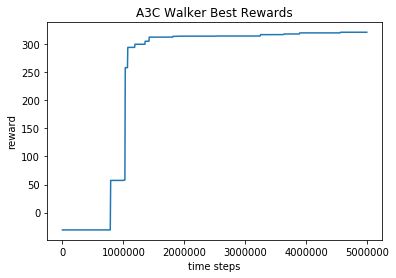

In [12]:
# Plot the rewards from the logger
import matplotlib.pyplot as plt
plt.title("A3C Walker Best Rewards")
plt.ylabel("reward")
plt.xlabel("time steps")
plt.plot(list(logger.time_steps), list(logger.best_reward))

/home/mustafa/anaconda3/envs/blg604ehw2/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
False
Done!
320.61000971095405


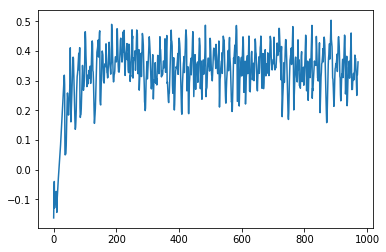

In [20]:
# Just to save a video of the walker walking
import torch
env = walker_env()
eps_reward = 0
best_model = best_agent
rewards = []
hx, cx = torch.zeros(1, 128), torch.zeros(1, 128)
render = True

best_agent.eval()
monitor_path = "Walker/" + str(a3c_args.maxtimestep) + " timestep"
model_path = "monitor/Walker/model_state_dict"

if monitor_path:
    path = "monitor/" + monitor_path
    env = gym.wrappers.Monitor(
        env, path, video_callable=lambda eps_id: True, force=True)
    render = False
    
state = env.reset()
state = torch.from_numpy(state).unsqueeze(0).float()
while True:
    action, (hx, cx) = best_model.greedy_policy((state, (hx, cx)))
    if render:
        env.render()

    state, reward, done, _ = env.step(action)
    state = torch.from_numpy(state).unsqueeze(0).float()
    eps_reward += reward
    rewards.append(reward)
    
    if done:
        print('Done!')
        break

print(eps_reward)
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.show()
env.close()

# torch.save(best_agent.state_dict(), model_path)

### b) Breakout with Asynchronous Advantage Actor-Critic (30)

- It takes a lot of time so be prepared.

In [78]:
from blg604ehw2.atari_wrapper import ClipRewardEnv
from blg604ehw2.atari_wrapper import FrameStack
from blg604ehw2.atari_wrapper import EpisodicLifeEnv
from blg604ehw2.atari_wrapper import WarpFrame
from blg604ehw2.atari_wrapper import ScaledFloatFrame
from blg604ehw2.atari_wrapper import FireResetEnv

from blg604ehw2.network import Cnn
from blg604ehw2.network import DiscreteDistHead
from blg604ehw2.network import a3c_discrete

from blg604ehw2.a3c import DiscreteA3c


# Breakout Environment
envname = "Breakout-v4"
Logger = namedtuple("Logger", "eps_reward best_reward best_model time_steps time")

# Hyperparameters
breakout_args = A3C_args(
    **dict(
        maxtimestep=2000000,
        maxlen=2000,
        nstep=20,
        gamma=0.98,
        lr=0.00003,
        beta=0.01,
        device="cpu",
    )
)

def breakout_agent():
#     feature_net = Cnn(4, 512) # 4 channel size because of the StackFrame buffer
#     head_net = DiscreteDistHead(512, 4) # 4 output because of the environment's action space
#     network = Network(feature_net, head_net)

    # The previous model didn't get me where I wanted
    # So I tried my own model
    network = a3c_discrete(4, 4)

    agent = DiscreteA3c(network)
    agent.device = breakout_args.device
    return agent

def breakout_env():
    env = gym.make(envname)
    env = ClipRewardEnv(env)            # Clip the reward between -1 and 1
    env = WarpFrame(env)                # Downsample rgb (210, 160, 3) images to gray images (84, 84)
    env = EpisodicLifeEnv(env)          # Terminate the environment after a live is lost
    env = FrameStack(env, k=4)          # Stack consecutive frames as a single state
    env = FireResetEnv(env)             # To start the game at the beginning or when it is done 
    return env

In [81]:
### Main cell for Breakout ###

N_PROCESSES = 16

global_agent = breakout_agent()
global_agent.share_memory()
sharedopt = SharedAdam(global_agent.parameters(), lr=breakout_args.lr)

best_agent = breakout_agent()
best_agent.share_memory()

# Try to use one manager
# manager = mp.Manager()
logger = Logger(
    manager.list(),
    manager.list(),
    best_agent,
    manager.list(),
    manager.Value("i", 0)
)

lock = mp.Lock() 

processes = []

process = mp.Process(target=test_worker,
                     args=(breakout_args, global_agent, breakout_env, breakout_agent, lock, logger))
process.start()
processes.append(process)
for t in range(N_PROCESSES):
    process = mp.Process(target=train_worker,
                         args=(breakout_args, global_agent, sharedopt, breakout_env, breakout_agent, lock, logger))
    process.start()
    processes.append(process)

for p in processes:
    p.join()

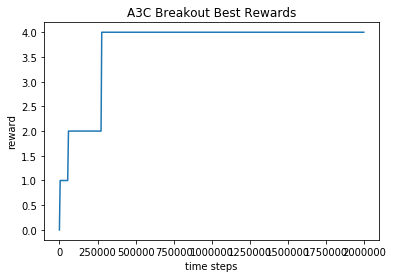

In [83]:
# Plot the rewards from the logger
import matplotlib.pyplot as plt
plt.title("A3C Breakout Best Rewards")
plt.ylabel("reward")
plt.xlabel("time steps")
plt.plot(list(logger.time_steps), list(logger.best_reward))

In [89]:
# Save the best model's parameters
model_path = "monitor/Breakout/model_state_dict"
torch.save(logger.best_model.state_dict(), model_path)